In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
import json

# 1 - VERIFYING THE GROUPS

let us test if the groups are well formed

Step 1 : making the groups

In [2]:
#similarity scores for tools
with open('/home/marinedjaffardjy/Documents/Code/Similarite_process/json/levenshtein_snk_tools/levenshtein_tools_snk_5887.json') as f1:
    scores = json.load(f1)
#snakemake rules
with open('/home/marinedjaffardjy/Documents/Code/Investigating_reuse/json/snk_rule_info_tool.json') as f:
    snk_rules = json.load(f)

In [3]:
def make_matrix_scores(snk_rules,scores,rg):
    matrix_scores = []
    proc_names = [rule1["wf_orig"]+"/"+rule1["name"] for rule1 in snk_rules]
    scores_cl = scores.copy()
    z = 0
    #for i in range(len(snk_rules)-1,0,-1) :
    for i in range(0,rg) :
        new_scores = [el["levenshtein"] for el in scores_cl[:len(snk_rules)-1-i]]
        scores_el = [1]+new_scores
        scores_cl = scores_cl[len(snk_rules)-1-i:]
        zeros = np.zeros(z)
        z+=1
        matrix_scores.append(list(zeros)+scores_el)
    return matrix_scores

In [6]:
%%time
matrix_scores=make_matrix_scores(snk_rules,scores,5888)

CPU times: user 8min 34s, sys: 1min 49s, total: 10min 23s
Wall time: 10min 26s


In [7]:
def grouping(matrix_scores, treshold, snk_rules):
    #input
    #output
    #getting the similarity groups per line
    tab_sim = []
    for line in matrix_scores:
        simil = []
        for i in range(0,len(line)):
            if(line[i]>=treshold):
                simil.append(i)
            i+=1
        tab_sim.append(simil)
    #transitivity
    #grouping the similarity groups by parsing the matrix x times (x = nb of processes)
    #TODO : optimiser
    
    for i in range(len(snk_rules)-1,-1,-1):
        new_line = []
        to_pop = []
        for line_nb in range(0,len(tab_sim)):
            if i in tab_sim[line_nb]:
                new_line = new_line+tab_sim[line_nb]
                to_pop.append(line_nb)
        to_pop.sort(reverse=True)
        for p in to_pop:
            tab_sim.pop(p)
        tab_sim.append(list(set(new_line)))
            
    #translate the groups into snk rules
    simil_snk=[]
    for group in tab_sim:
        group_snk = []
        for el in group:
            group_snk.append(snk_rules[el])
        simil_snk.append(group_snk)
    return simil_snk
        
        

In [8]:
%%time
group_snk = grouping(matrix_scores,0.85,snk_rules)

CPU times: user 5.52 s, sys: 845 µs, total: 5.52 s
Wall time: 5.53 s


In [10]:
# groupes bien formés ?
sum_elements = 0
for el in group_snk:
    sum_elements+=len(el)
sum_elements

5888

In [12]:
groups_not_one=[]
for el in group_snk:
    if(len(el)>1):
        groups_not_one.append(el)
len(groups_not_one)

174

In [13]:
lens_gno=[len(el) for el in groups_not_one]
print(max(lens_gno))
print(min(lens_gno))
print(np.mean(lens_gno))

3414
2
22.00574712643678


In [40]:
i=0
for group in group_snk:
    if(len(group)==3414):
        print(i)
    i+=1

2176


In [41]:
group_snk[2176]

[{'name': 'Merge_Pairs_With_Flash',
  'code': '(name=\'Merge_Pairs_With_Flash\', lineno=508, snakefile=\'/home/marinedjaffardjy/Documents/wf_features/data/inputs/data/Aexbrayat/snakevir/1.snakefile\')\n\n@workflow.input(\n\tpairs_R1 = "FilteredFastq/filtered_bacteria_{smp}_R1.fastq" ,\n\tpairs_R2 = "FilteredFastq/filtered_bacteria_{smp}_R2.fastq" ,\n)\n\n@workflow.params(\n\tprefix = "FilteredFastq/{smp}" ,\n\tflash = scriptdir + "flash"\n)\n\n@workflow.output(\n\text = "FilteredFastq/{smp}.extendedFrags.fastq" ,\n\tR1 = "FilteredFastq/{smp}.notCombined_1.fastq" ,\n\tR2 = "FilteredFastq/{smp}.notCombined_2.fastq"\n)\n\n@workflow.benchmark(\n\t"benchmarks/{smp}.Merge_Pairs_With_Flash.benchmark.txt"\n)\n\n@workflow.log(\n\t"logs/logsFLASH/{smp}_flash.log"\n)\n@workflow.shellcmd (\n\t"""\n\t\tflash -M 250 {input.pairs_R1} {input.pairs_R2} -o {params.prefix} &> {log}\n\t\t"""\n\n\t# Create a single file for merge and windows reads\n\n)\n@workflow.run\ndef __rule_Merge_Pairs_With_Flash(inpu

In [54]:
max(elements_big_group)

5887

In [49]:
elements_big_group = [snk_rules.index(el) for el in group_snk[2176]]

In [51]:
simil_elements_big_group = [sum([el>0.85 for el in matrix_scores[el2]]) for el2 in elements_big_group]

In [52]:
max(simil_elements_big_group)

33

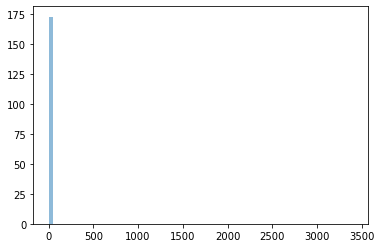

In [38]:
#taking a look at the repartition of the groups sizes
bins_lev= np.arange(0, max(lens_gno), 50)
plt.hist(lens_gno,bins=bins_lev, alpha=0.5)
plt.show()

the forced transitivity seems flawed. Another method will need to be found in order to solve this issue

to compare metrics for the tool metric :
- max : 169
- min : 1
- mean : 8.173076923076923

### Step 2 - On one line of the matrix, do all the elements contain the same tools ?

In [17]:
groups_not_one[0][0].keys()

dict_keys(['name', 'code', 'owner', 'wf_orig', 'tools', 'extr_tools'])

In [26]:
i = 0
groups_not_same_tools=[]
for group in groups_not_one:
    same=True
    for el in group:
        if(el['tools']!=group[0]['tools']):
             same=False
    if(same==False):
        groups_not_same_tools.append(i)
        print(i)
        print("max nb of tools = "+str(max([len(el['tools']) for el in group])))
    i+=1      
print(len(groups_not_same_tools))

2
max nb of tools = 1
3
max nb of tools = 1
4
max nb of tools = 2
5
max nb of tools = 1
6
max nb of tools = 1
7
max nb of tools = 2
8
max nb of tools = 1
9
max nb of tools = 1
10
max nb of tools = 1
11
max nb of tools = 1
12
max nb of tools = 1
13
max nb of tools = 1
14
max nb of tools = 5
15
max nb of tools = 3
16
max nb of tools = 1
17
max nb of tools = 1
18
max nb of tools = 3
19
max nb of tools = 1
20
max nb of tools = 1
21
max nb of tools = 1
22
max nb of tools = 1
23
max nb of tools = 1
24
max nb of tools = 2
25
max nb of tools = 2
26
max nb of tools = 1
27
max nb of tools = 1
28
max nb of tools = 2
29
max nb of tools = 2
30
max nb of tools = 2
31
max nb of tools = 1
32
max nb of tools = 1
34
max nb of tools = 1
35
max nb of tools = 3
36
max nb of tools = 4
37
max nb of tools = 1
38
max nb of tools = 2
39
max nb of tools = 2
40
max nb of tools = 1
41
max nb of tools = 1
42
max nb of tools = 1
43
max nb of tools = 3
44
max nb of tools = 1
45
max nb of tools = 1
46
max nb of tools 

So not all similarity groups are groups that contain the same element, however we can argue that even though this happens with almost 50% of the groups, the maximum number of tools is usually rather small (around 1 or 2 tools, maximum 9 tools which is a large number but is also very occasional)